In [9]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import os
import pandas as pd
import torch
import seaborn as sns
import ast

In [23]:
def load_data(REPO_PATH, dataset_name, country_list):
    # Directory containing CSV files
    directory = f'{REPO_PATH}/Embeddings/Image/'

    # Get a list of all filenames in each directory
    file_list = [file for file in os.listdir(directory) if file.startswith(dataset_name)]

    # Initialize an empty list to store DataFrames
    dfs = []


    # Iterate through the files, read them as DataFrames, and append to the list
    for file in file_list:
        file_path = os.path.join(directory, file)
        df = pd.read_csv(file_path)
        dfs.append(df)

    # Concatenate all DataFrames in the list into a single DataFrame
    combined_df = pd.concat(dfs, ignore_index=True)

    europe_countries = country_list[(country_list['Continent'] == 'Europe')]
    europe_country_list = europe_countries['Country'].tolist()
    mask = combined_df['label'].isin(europe_country_list)
    europe_combined_df = combined_df[mask]

    # map contries to regions
    combined_df = pd.merge(europe_combined_df,country_list,left_on='label',right_on='Country')
    return combined_df

In [11]:
def transform_to_tensor(x):
    # model_input_str = eval(x)
    # model_input_array = np.frombuffer(model_input_str, dtype=np.float32)
    # model_input = model_input_array.tolist()
    # return model_input
    start = x.find('[[')
    end = x.find(']]')+2
    x = x[start:end]
    image_embedding = torch.tensor(ast.literal_eval(x))
    image_embedding_values = np.array(image_embedding.flatten().tolist()).reshape(1, -1)
    return image_embedding_values

In [24]:
REPO_PATH = '/home/kieran/Documents/Uni/WiSe23-24/Good_Practices_of_Machine_Learning/good_practices_ml/'
country_list = pd.read_csv(f'{REPO_PATH}/data_finding/country_list_region_and_continent.csv')

#set dataset_name
# dataset_name = 'bigfoto'
# dataset_name = 'aerial'
dataset_name = 'geoguessr'

#Load Data
combined_df = load_data(REPO_PATH, dataset_name, country_list)
y = combined_df['label'].to_numpy()
regions = []
for elem in y:
    country_row = country_list.loc[country_list['Country'] == elem].iloc[0]
    regions.append(country_row['Intermediate Region Name'])

# Get sets of country, region and continent classes
country_classes = np.unique(y)
region_classes = np.unique(regions)

#Create numpy array for TSNE
X = combined_df["Embedding"].apply(transform_to_tensor).to_list()
feat_cols = [ 'pixel'+str(i) for i in range(len(X[0])) ]
X = np.array(X)
X = np.squeeze(X)
print(X.shape)

# Run TSNE
tsne = TSNE(n_components=2, verbose=1, init='pca')
tsne_results = tsne.fit_transform(X)

(18117, 512)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 18117 samples in 0.004s...
[t-SNE] Computed neighbors for 18117 samples in 2.844s...
[t-SNE] Computed conditional probabilities for sample 1000 / 18117
[t-SNE] Computed conditional probabilities for sample 2000 / 18117
[t-SNE] Computed conditional probabilities for sample 3000 / 18117
[t-SNE] Computed conditional probabilities for sample 4000 / 18117
[t-SNE] Computed conditional probabilities for sample 5000 / 18117
[t-SNE] Computed conditional probabilities for sample 6000 / 18117
[t-SNE] Computed conditional probabilities for sample 7000 / 18117
[t-SNE] Computed conditional probabilities for sample 8000 / 18117
[t-SNE] Computed conditional probabilities for sample 9000 / 18117
[t-SNE] Computed conditional probabilities for sample 10000 / 18117
[t-SNE] Computed conditional probabilities for sample 11000 / 18117
[t-SNE] Computed conditional probabilities for sample 12000 / 18117
[t-SNE] Computed conditional probabil

In [27]:
region_result_array = []
for elem in y:
    country_row = country_list.loc[country_list['Country'] == elem].iloc[0]
    region_result_array.append(country_row['Intermediate Region Name'])

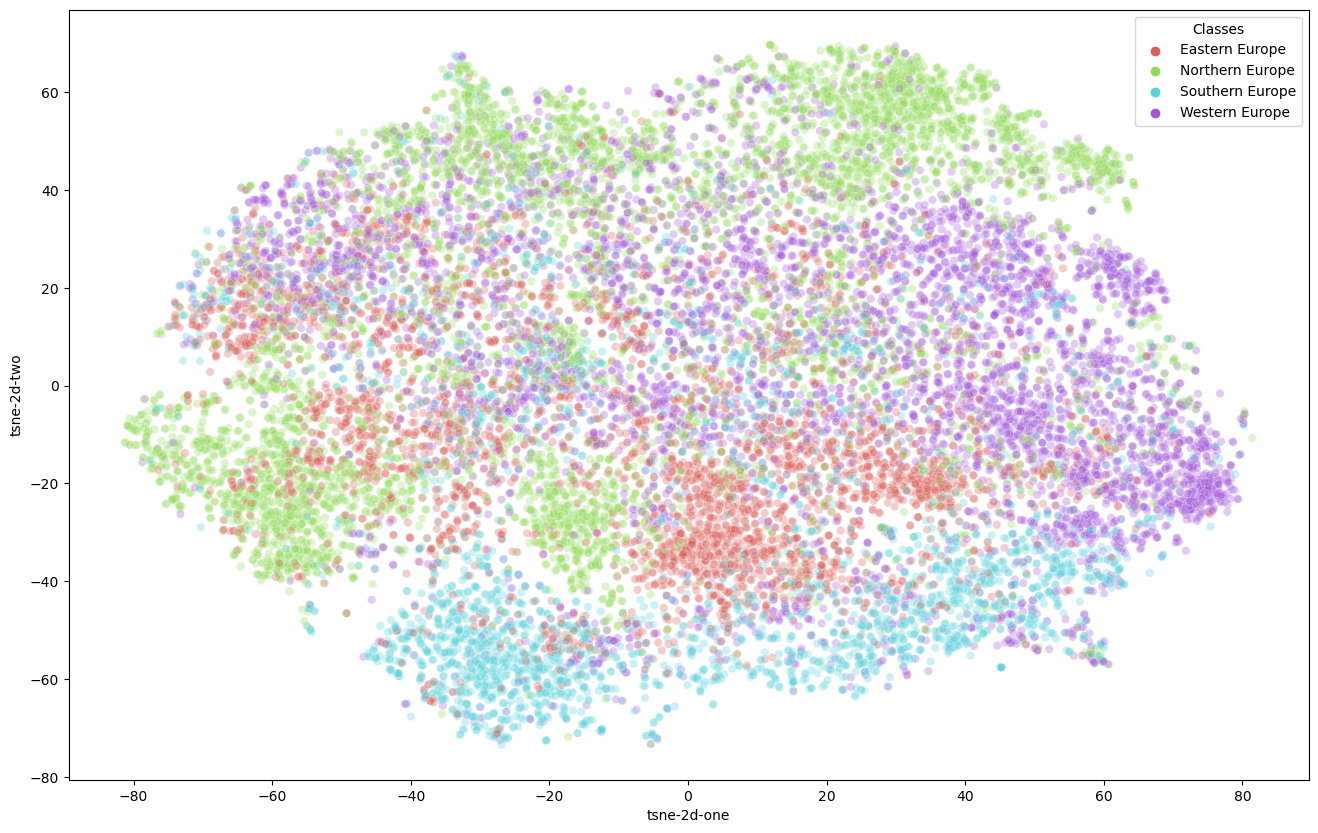

In [28]:
df_subset = pd.DataFrame()
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
if not os.path.isdir(f'./{dataset_name}/Europe'):
    os.mkdir(f'./{dataset_name}/Europe')
df_subset['Classes'] = region_result_array

color_palette = sns.color_palette("hls", len(region_classes)).as_hex()

plt.figure(figsize=(16,10), clear=True)
scatterplot = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="Classes",
    hue_order=region_classes,
    palette=sns.color_palette(color_palette),
    data=df_subset,
    legend="full",
    alpha=0.3
)
scatterplot.figure.savefig(f'./{dataset_name}/Europe/output.png')

In [29]:
region_specific_labels = []
for region in region_classes:
    result_array = []
    for elem in y:
        country_row = country_list.loc[country_list['Country'] == elem].iloc[0]
        if country_row['Intermediate Region Name'] == region:
            result_array.append(elem)
        else:
            result_array.append('Other')
    region_specific_labels.append(result_array)

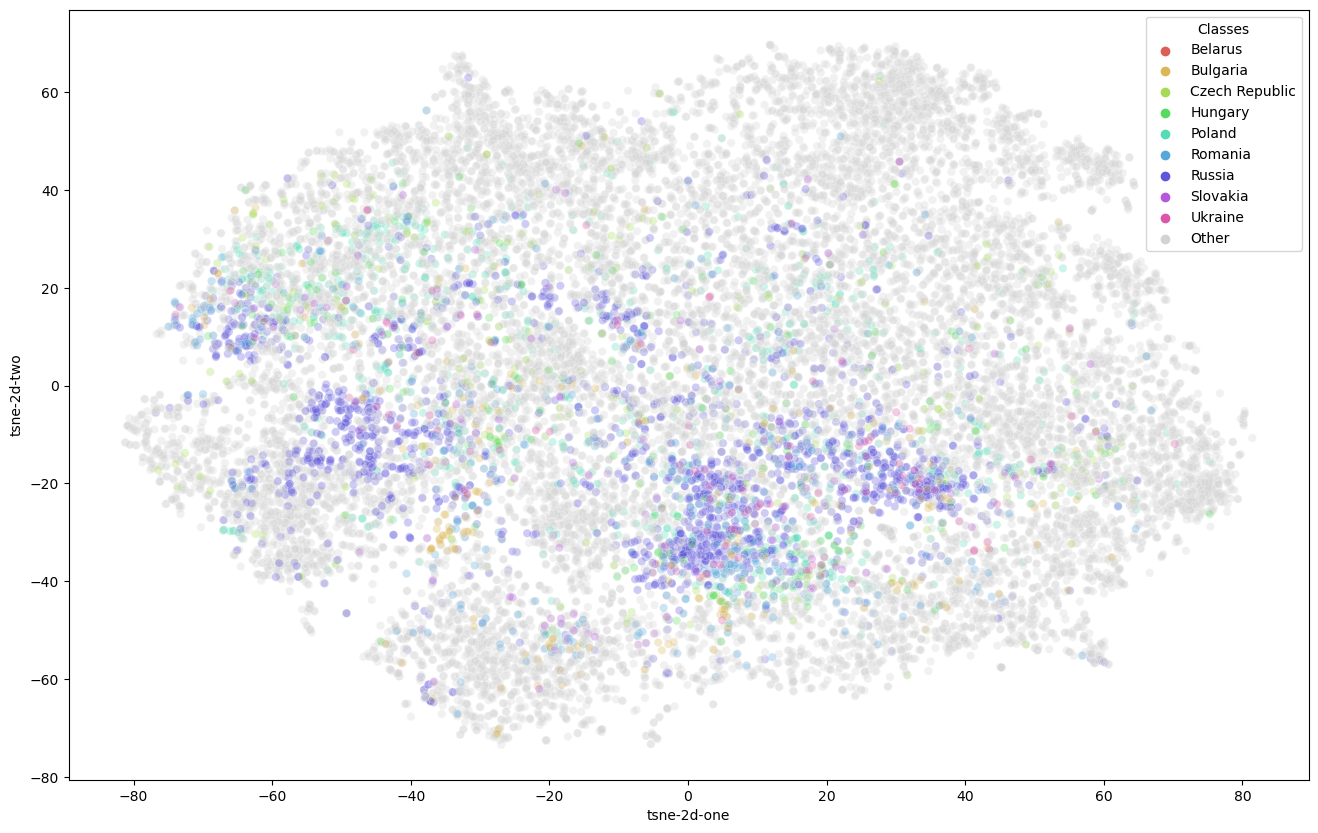

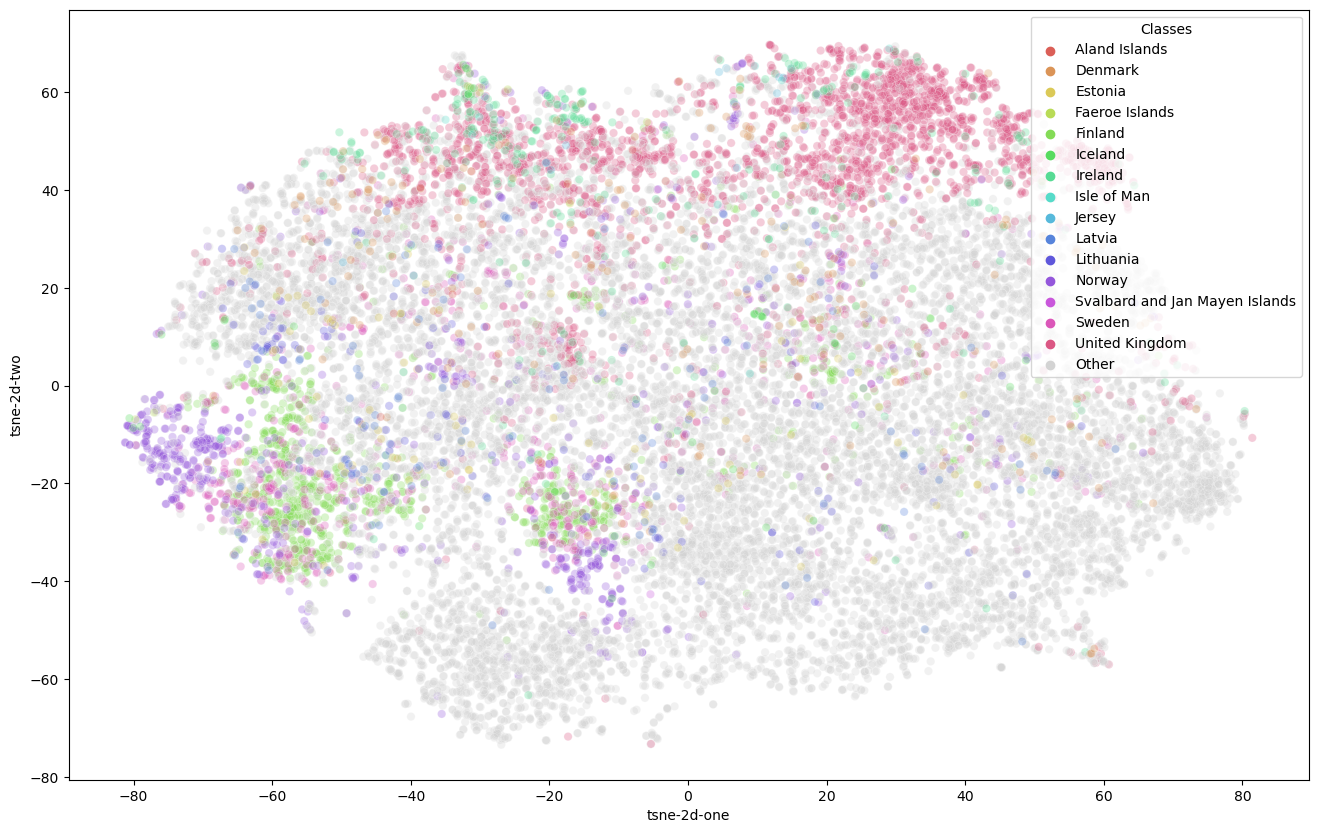

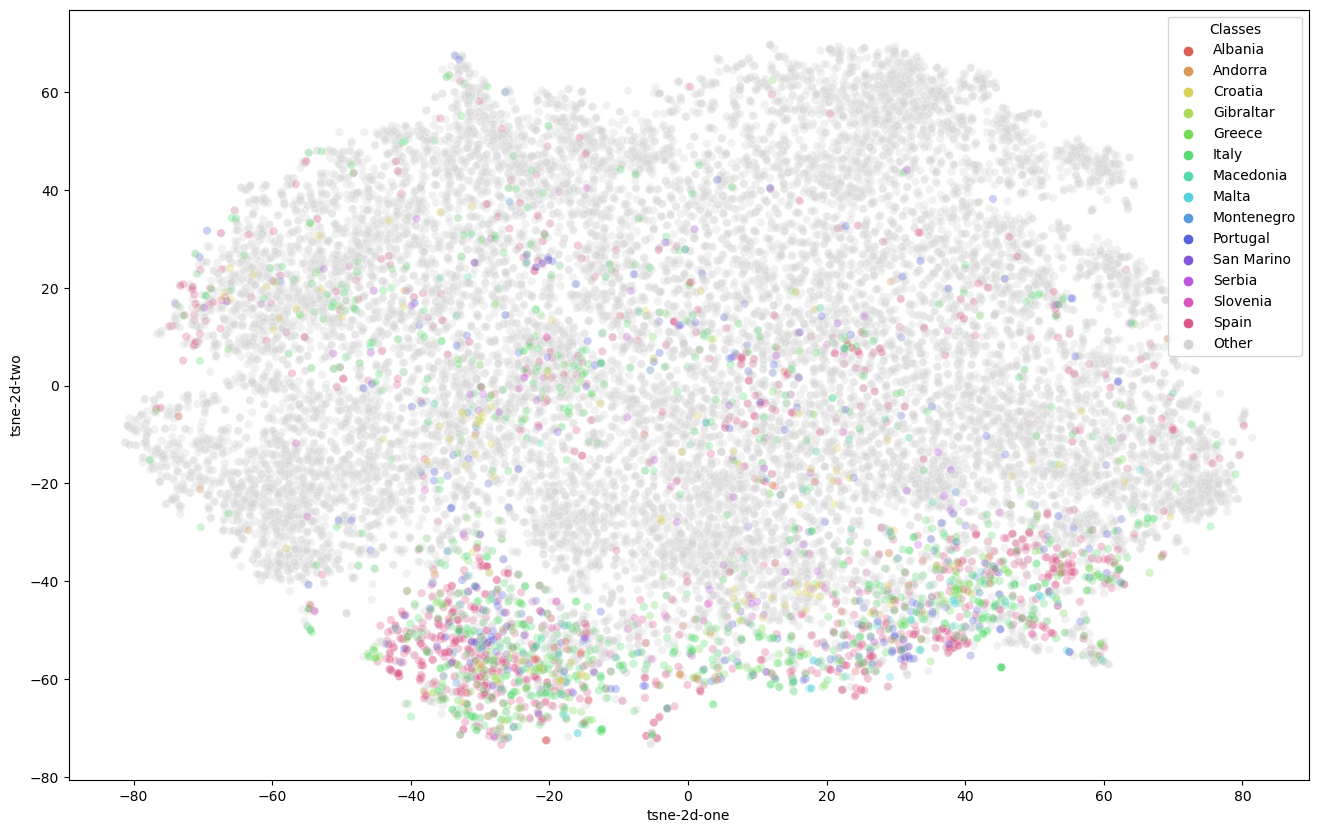

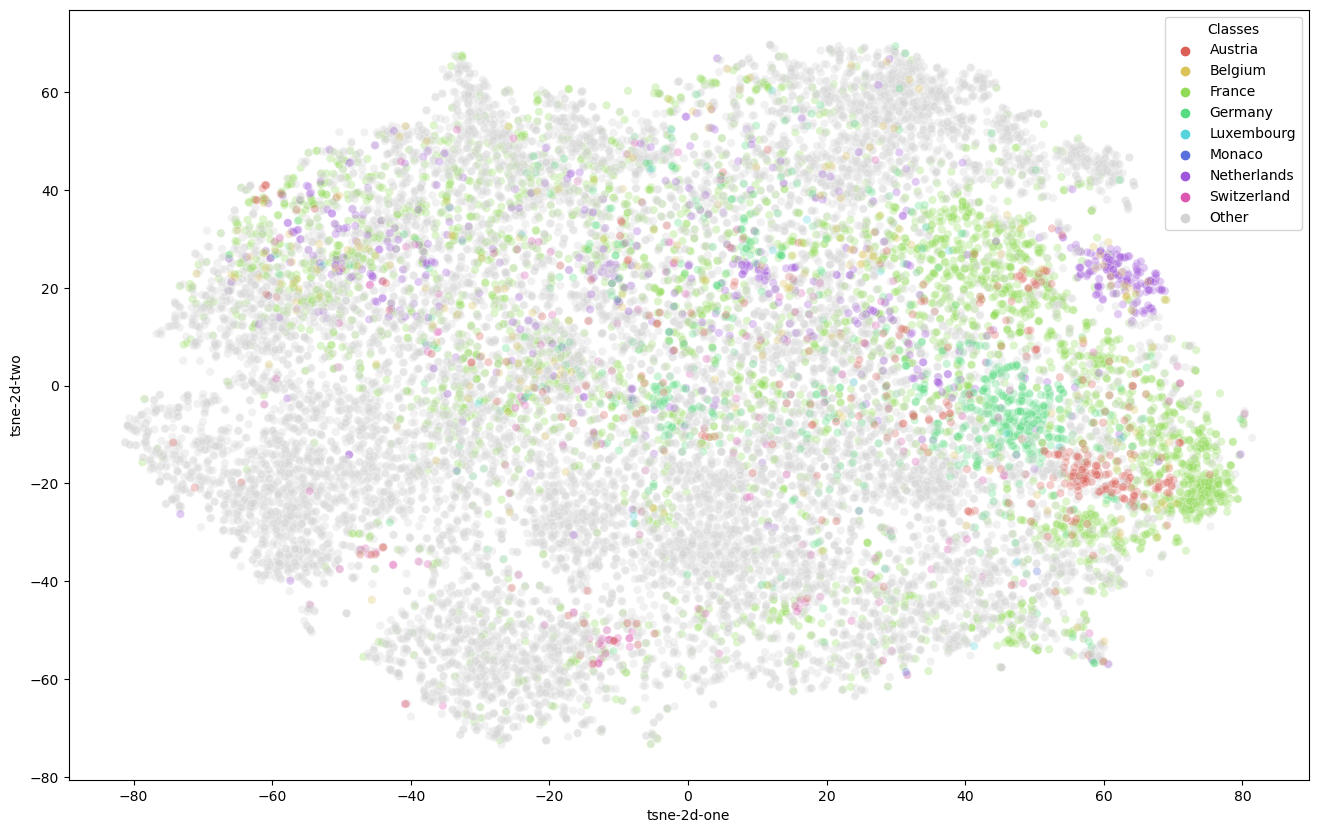

In [30]:
df_subset = pd.DataFrame()
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
if not os.path.isdir(f'./{dataset_name}/Europe/Region'):
    os.mkdir(f'./{dataset_name}/Europe/Region')
for i in range(0, len(region_specific_labels)):
    df_subset['Classes'] = region_specific_labels[i]

    unique_classes = np.unique(region_specific_labels[i])
    modified_unique = list(np.delete(unique_classes, np.where(unique_classes == 'Other')))
    color_palette = sns.color_palette("hls", len(modified_unique)).as_hex()
    color_palette.append('#d3d3d3')
    modified_unique.append('Other')

    plt.figure(figsize=(16,10), clear=True)
    scatterplot = sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="Classes",
        hue_order=modified_unique,
        palette=sns.color_palette(color_palette),
        data=df_subset,
        legend="full",
        alpha=0.3
    )
    if not os.path.isdir(f'./{dataset_name}/Europe/Region/{region_classes[i]}'):
        os.mkdir(f'./{dataset_name}/Europe/Region/{region_classes[i]}')
    scatterplot.figure.savefig(f'./{dataset_name}/Europe/Region/{region_classes[i]}/output.png')